In [1]:
%matplotlib inline

import numpy as np

import pandas as pd
from pandas_datareader import data

import matplotlib.pyplot as plt
import matplotlib.finance as mfinance
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.transforms as mtransforms

from statsmodels import stats
import scipy.optimize as opt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression

import theano
import theano.tensor as T

In [2]:
from_date = '2015-01-01'
to_date = '2016-03-01'
stock_symbols = ['AAPL','GOOG','AMZN','FB','MSFT']
stocks = {}
for symbol in stock_symbols:
    stocks[symbol] = data.DataReader(symbol,'yahoo',from_date,to_date)

benchmark_symbol = 'SPY'
benchmark = data.DataReader(benchmark_symbol,'yahoo',from_date,to_date)

In [21]:
class Order(object):
    def __init__(self):
        pass
    
class MarketOrder(Order):
    def __init__(self,symbol,amount):
        self._symbol = symbol
        self._amount = amount

class LimitOrder(Order):
    def __init__(self,symbol,price,amount):
        self._symbol = symbol
        self._price = price
        self._amount = amount

class Asset(object):
    def __init__(self,price,amount):
        self._avg_price = float(price)
        self._amount = float(amount)
    def add(self,price,amount):
        self._avg_price = (self._avg_price * self._amount + price * amount) / (self._amount + amount)
        self._amount += amount
        return True
    def remove(self,amount):
        if self._amount >= amount:
            self._amount -= amount
            if self._amount == 0:
                self._avg_price = 0
            return True
        return False
        
class Portfolio(object):
    def __init__(self):
        self._assets = {}
    def add_asset(self,symbol,price,amount):
        if not symbol in self._assets:
            self._assets[symbol] = Asset(0,0)
        return self._assets[symbol].add(price,amount)
    def remove_asset(self,symbol,amount):
        if symbol in self._assets:
            return self._assets[symbol].remove(amount)
        return False
    def get_asset_avg_price(self,symbol):
        if symbol in self._assets:
            return self._assets[symbol]._avg_price
        return 0
    def get_asset_amount(self,symbol):
        if symbol in self._assets:
            return self._assets[symbol]._amount
        return 0
    
class Context(object):
    def __init__(self,initial_cash):
        self._initial_cash = initial_cash
        self._available_cash = initial_cash
        self._total_cash_for_buying = 0.
        self._total_cash_for_selling = 0.
        self._portfolio = Portfolio()
        
class QSystem(object):
    
    def __init__(self,from_date,to_date,
                 data,benchmark_data,initial_cash,initialize=None,handle_data=None):
        self._data = data
        self._benchmark_data = benchmark_data
        self._from_date = from_date
        self._to_date = to_date
        self._orders = []
        self._context = Context(initial_cash)
        self._context.order = self._order
        self._context.evaluation = self.evaluation
        self._context.record = self._record
        self._current_date = None
        self._initialize = initialize
        self._handle_data = handle_data
        self._buy_history = []
        self._sell_history = []
        self._history = {}
        
    def run(self):
        self._current_date = pd.Timestamp(self._from_date)
        self._process_initialize()
        self._benchmark_initial_price = self._benchmark_data.loc[self._current_date,:]
        
        _to = pd.Timestamp(self._to_date)
        _delta = pd.Timedelta(days=1)
        
        while self._current_date != _to:
            try:
                self._process_handle_data(self._data.loc[:,:self._current_date,:],
                                          self._benchmark_data.loc[:self._current_date,:])
            except Exception as e:
                print str(e)
                
            self._current_date += _delta
            self._process_order(self._current_date)
            
    def _order(self,order):
        self._orders.append(order)
        
    def _process_initialize(self):
        if self._initialize is not None:
            self._initialize(self._context,
                             self._data.loc[:,:self._from_date,:],
                             self._benchmark_data.loc[:self._from_date,:])
    
    def _process_handle_data(self,data,meta_data):
        if self._handle_data is not None:
            self._handle_data(self._context,data,meta_data)
    
    def _process_order(self,current_date):
        while len(self._orders) > 0:
            self._orders.reverse()
            order = self._orders.pop()
            buying_price = -1
            selling_price = -1
            if isinstance(order,MarketOrder):
                try:
                    open_price = self._data[order._symbol]['Open'][current_date]
                    if order._amount > 0:
                        buying_price = open_price
                        if buying_price != -1:
                            self._process_buying(current_date,order._symbol,buying_price,order._amount)
                    else:
                        selling_price = open_price
                        if selling_price != -1:
                            self._process_selling(current_date,order._symbol,selling_price,np.abs(order._amount))
                except KeyError:
                    pass
#                     print 'Not available date',current_date
            elif isinstance(order,LimitOrder):
                try:
                    high_price = self._data[order._symbol]['High'][current_date]
                    low_price = self._data[order._symbol]['Low'][current_date]           
                    if order._amount > 0:
                        if order._price >= low_price and order._price <= high_price:                                
                            buying_price = order._price
                        elif order._price > high_price:
                            buying_price = high_price
                        elif order._price < low_price:
                            print 'The order hasnt been made', order._price, '<' , low_price
                        if buying_price != -1:
                            self._process_buying(current_date,order._symbol,buying_price,order._amount)
                    else:
                        if order._price >= low_price and order._price <= high_price:                                
                            selling_price = order._price
                        elif order._price < low_price:
                            selling_price = low_price
                        elif order._price > high_price:
                            print 'The order hasnt been made', order._price, '>' , high_price
                        self._process_selling(current_date,order._symbol,selling_price,np.abs(order._amount))
                except KeyError:
                    pass
#                     print 'Not available date',current_date
            else:
                print 'none'
        
    def _process_buying(self,current_date,symbol,price,amount):
#         print '_process_buying',current_date,symbol,price,amount
        if self._context._available_cash >= price * amount:
            if self._context._portfolio.add_asset(symbol,price,amount):
                self._context._available_cash -= price * amount
                self._context._total_cash_for_buying += price * amount
                self._buy_history.append([current_date,symbol,price,amount])
#         else:
#             print 'Not enought cash to buy'
            
    def _process_selling(self,current_date,symbol,price,amount):
#         print '_process_selling',current_date,symbol,price,amount
        if self._context._portfolio.get_asset_amount(symbol) >= amount:
            if self._context._portfolio.remove_asset(symbol,amount):
                self._context._available_cash += price * amount
                self._context._total_cash_for_selling += price * amount
                self._sell_history.append([current_date,symbol,price,amount])
#         else:
#             print 'Not enought amount to sell'
        
    def evaluation(self):
        print '##### evaluation ########'
        try:
            total_valuation = 0.
            portfolio_valuation = 0.
            for symbol in self._context._portfolio._assets: 
                print symbol,self._context._portfolio.get_asset_amount(symbol),self._data[symbol]['Close'][self._current_date]
                portfolio_valuation += self._context._portfolio.get_asset_amount(symbol) * self._data[symbol]['Close'][self._current_date]
            total_valuation = self._context._available_cash + portfolio_valuation
            print 'total valuation : ', total_valuation, total_valuation/self._context._initial_cash - 1.
            print 'benchmark return : ', self._benchmark_initial_price['Close']/self._benchmark_data['Close'][self._current_date] - 1
        
        except KeyError as e:
            print str(e)
        print '#########################'
        
    def _record(self,symbol,**kwarg):
        if not symbol in self._history:
            self._history[symbol] = {}
        for key in kwarg:
            value = kwarg[key]
            if not key in self._history[symbol]: 
                self._history[symbol][key] = []
            self._history[symbol][key].append(value)
                    
    def plot(self,symbol):
        prices = self._data[symbol]
        
        dates = [ mdates.date2num(date) for date in prices.index]
        open_prices = prices['Open']
        high_prices = prices['High']
        low_prices = prices['Low']
        close_prices = prices['Close']
        volumes = prices['Volume'] if 'Volume' in prices.columns else None

        chart_data = np.matrix([dates,open_prices,high_prices,low_prices,close_prices]).T.tolist()

        fig = plt.figure(figsize=(15,8))
        ax1 = plt.subplot2grid((5,4),(0,0),rowspan=4,colspan=4)
        mfinance.candlestick_ohlc(ax1,chart_data,colorup='r',colordown='b',alpha=0.7)
        ax1.grid(True)
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.ylabel('Price')

        ax2 = plt.subplot2grid((5,4),(4,0),sharex=ax1,rowspan=1,colspan=4)
        ax2.grid(True)
        
        fig.subplots_adjust(hspace=0)
        plt.setp( plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
        plt.setp(ax1.get_xticklabels(),visible=False)
        ax1.set_yticks(ax1.get_yticks()[1:])
        
        b = np.array(self._buy_history)
        s = np.array(self._sell_history)
        if len(b) > 0:
            idx_b = (b[:,1] == symbol)
            ax1.plot(b[idx_b,0],b[idx_b,2],'ro')
        if len(s) > 0:
            idx_s = (s[:,1] == symbol)
            ax1.plot(s[idx_s,0],s[idx_s,2],'bo')
        
        return ax1,ax2


In [22]:
class Strategy(object):
    def __init__(self,context):
        pass
    def is_enter(self,symbol,data):
        pass
    def is_exit(self,symbol,data):
        pass    
    def plot(self,symbol,data,ax):
        pass
    def optimize(self,symbol,data):
        pass
    
class GDCrossStrategy(Strategy):
    def __init__(self,context,short_ma=5,long_ma=14):
        self._context = context
        self._short_ma = short_ma
        self._long_ma  = long_ma
    def set_params(self,short_ma,long_ma):
        self._short_ma = short_ma
        self._long_ma  = long_ma
    def is_enter(self,symbol,data):
        price = data[symbol]['Close']
        short_ma_data = pd.rolling_mean(price,window=self._short_ma).dropna()
        long_ma_data = pd.rolling_mean(price,window=self._long_ma).dropna()
        if short_ma_data is None or len(short_ma_data) < 2:
            return False
        if long_ma_data is None or len(long_ma_data) < 2:
            return False
        if short_ma_data.values[-2] < long_ma_data.values[-2] and short_ma_data.values[-1] > long_ma_data.values[-1]:
            return True
        return False
    def is_exit(self,symbol,data):      
        price = data[symbol]['Close']
        short_ma_data = pd.rolling_mean(price,window=self._short_ma)
        long_ma_data = pd.rolling_mean(price,window=self._long_ma)
        if short_ma_data is None or len(short_ma_data) < 2:
            return False
        if long_ma_data is None or len(long_ma_data) < 2:
            return False
        if short_ma_data.values[-2] > long_ma_data.values[-2] and short_ma_data.values[-1] < long_ma_data.values[-1]:
            return True
        return False
    def plot(self,symbol,data,ax):      
        price = data[symbol]['Close']
        ma1 = pd.rolling_mean(price,window=self._short_ma).dropna()
        ma2 = pd.rolling_mean(price,window=self._long_ma).dropna()
        ma1.plot(ax=ax1)
        ma2.plot(ax=ax1)
    def optimize(self,symbol,data,short_ma_range=[5,6],long_ma_range=[14,15]):
        best_long_ma = None
        best_short_ma = None
        best_return = 0
        from_date = str(data.axes[1][0])
        to_date = str(data.axes[1][-1])
        for short_ma in short_ma_range:
            for long_ma in long_ma_range:
                self.set_params(short_ma,long_ma)
                _from = pd.Timestamp(from_date)
                _to = pd.Timestamp(to_date)
                _delta = pd.Timedelta(days=1)
                buying_price = []
                selling_price = []
                while _from != _to:
                    if self.is_enter(symbol,data.loc[:,:_from,:]):
                        try:
                            buying_price.append(data[symbol]['Open'][_from+_delta])
                        except Exception as e:
                            pass
#                             print 'optimize error ',str(e)
                    if self.is_exit(symbol,data.loc[:,:_from,:]):
                        try:
                            selling_price.append(data[symbol]['Open'][_from+_delta])
                        except Exception as e:
                            pass
#                             print 'optimize error ',str(e)
                    _from += _delta
                if np.mean(selling_price)/np.mean(buying_price) > best_return:
                    best_long_ma = long_ma
                    best_short_ma = short_ma
                    best_return = np.mean(selling_price)/np.mean(buying_price)
        print 'optimize : ',symbol, 'best params : ',best_short_ma,best_long_ma,best_return
        if best_short_ma is not None and best_long_ma is not None:
            self.set_params(best_short_ma,best_long_ma)
        return best_short_ma,best_long_ma
    
class BollingerBand(object):
    def __init__(self,context=None,ma=14,std=2):
        self._ma = ma
        self._std = std
        
    def get_value(self,symbol,data):
        price = data[symbol]['Close']
        ma1 = pd.rolling_mean(price,window=self._ma).dropna()
        ma2 = pd.rolling_std(price,window=self._ma).dropna()
        up = ma1 + self._std*ma2
        down = ma1 - self._std*ma2
        return ma1[-1],up[-1],down[-1]
        
    def plot(self,symbol,data,ax):
        price = data[symbol]['Close']
        ma1 = pd.rolling_mean(price,window=self._ma).dropna()
        ma2 = pd.rolling_std(price,window=self._ma).dropna()
        ma1.plot(ax=ax)
        (ma1 + self._std*ma2).plot(ax=ax)
        (ma1 - self._std*ma2).plot(ax=ax)
        
class RSI(object):
    def __init__(self,context=None,window=14):
        self._context = context
        self._window = window
    
    def get_value(self,symbol,data):
        price = data[symbol]['Close']
        diff = price[-self._window+1:].values - price[-self._window:-1].values
        s1 = np.sum(np.abs(diff[diff >= 0]))
        s2 = np.sum(np.abs(diff[diff < 0]))
        return (s1/(s1+s2)) * 100.
    
    def plot(self,symbol,data,ax):
        price = data[symbol]['Close']
        def rsi_func(data):
            diff = data[1:] - data[:-1] 
            s1 = np.sum(np.abs(diff[diff >= 0]))
            s2 = np.sum(np.abs(diff[diff < 0]))
            return (s1/(s1+s2)) * 100.
        result = pd.rolling_apply(price,window=14,func=rsi_func).dropna()
        result.plot(ax=ax)
        
class MACD(object):
    def __init__(self,context=None,short_ma=12,long_ma=26,signal=9):
        self._context = context
        self._short_ma = short_ma
        self._long_ma = long_ma
        self._signal = signal
    
    def get_value(self,symbol,data):
        price = data[symbol]['Close']
        short_ma = pd.rolling_mean(price,window=self._short_ma)
        long_ma = pd.rolling_mean(price,window=self._long_ma)
        macd_line = (short_ma - long_ma).dropna()
        macd_signal = pd.rolling_mean(macd_line,window=self._signal).dropna()
        return macd_line[-1],macd_signal[-1]
    
    def plot(self,symbol,data,ax):
        price = data[symbol]['Close']
        short_ma = pd.rolling_mean(price,window=self._short_ma)
        long_ma = pd.rolling_mean(price,window=self._long_ma)
        macd_line = (short_ma - long_ma).dropna()
        macd_signal = pd.rolling_mean(macd_line,window=self._signal).dropna()
        macd_line.plot(ax=ax)
        macd_signal.plot(ax=ax)

optimize :  AAPL best params :  5 14 1.0173703022
optimize :  AMZN best params :  6 15 1.05180361058
optimize :  FB best params :  5 15 0.987936521943
optimize :  GOOG best params :  5 15 0.975447682346
optimize :  MSFT best params :  6 14 1.01432690523
##### evaluation ########
GOOG 0.0 718.809998
FB 100.0 109.82
AMZN 100.0 579.039978
AAPL 100.0 100.529999
MSFT 100.0 52.580002
total valuation :  100533.9868 0.005339868
benchmark return :  0.0679420823384
#########################


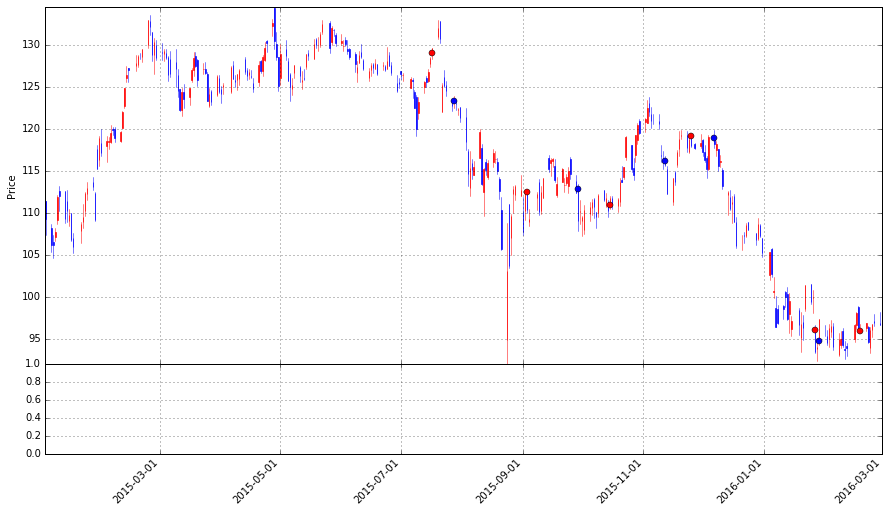

In [23]:
def extract_features(data):
    pass

def construct_training_data(data):
    pass

def make_model(data):
    pass

def initialize(context,data,benchmark_data):
    context.strategies = {}
    for symbol in data:
        s = GDCrossStrategy(context)
        s.optimize(symbol,data)
        context.strategies[symbol] = s
    
def handle_data(context,data,benchmark_data):
    for symbol in data:
        if context.strategies[symbol].is_enter(symbol,data):
            context.order(MarketOrder(symbol,100))
        if context.strategies[symbol].is_exit(symbol,data):
            context.order(MarketOrder(symbol,-100))
            
symbol = 'AAPL'
from_date = '2015-06-01'
to_date = '2016-03-01'
sdata = pd.Panel(stocks)
bdata = benchmark
initial_cash = 100000

q = QSystem(from_date,
            to_date,
            sdata,bdata,initial_cash,initialize,handle_data)  
q.run()
q.evaluation()
ax1,ax2 = q.plot(symbol)

# print bdata.loc[pd.Timestamp('2015-01-05'),:]

# b = BollingerBand()
# b.plot(symbol,sdata,ax1)
# print b.get_value(symbol,sdata)

# r = RSI()
# r.plot(symbol,sdata,ax2)
# print r.get_value(symbol,sdata)

# m = MACD()
# print m.get_value(symbol,sdata)
# m.plot(symbol,sdata,ax2)

# print price

In [ ]:
class Stock(object):
    def __init__(self,symbol,data):
        self._symbol = symbol
        self._data = data
    def compute_alpha_beta(self,benchmark):
        ret = self._data['Close'].pct_change()[1:].values.reshape(-1,1)
        benchmart_ret = benchmark['Close'].pct_change()[1:].values.reshape(-1,1)
        reg = LinearRegression()
        reg.fit(X=benchmart_ret,y=ret)
        self._beta = reg.coef_[0,0]
        self._alpha = reg.intercept_[0]

class MonetaryStrategy(object):
    def __init__(self,context):
        pass
    def isBuying(self,symbol,data):
        pass
    def isSelling(self,symbol,data):
        pass    
    
class SimpleMonetaryStrategy(MonetaryStrategy):
    def __init__(self,context):
        self._context = context
    def isBuying(self,symbol,data):
        current_price = data[symbol]['Close'][-1]
        avg_price = self._context._portfolio.get_asset_avg_price(symbol)
        amount = self._context._portfolio.get_asset_amount(symbol)
        total_price = avg_price * amount
        rate = total_price / self._context._initial_cash
    def isSelling(self,symbol,data):
        pass    